# Population Prediction using PCA and Random Forests

In [1]:
library("gdsfmt")
library("SNPRelate")
library("randomForest")
library("plyr")
library("caret")

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



## Input/Output Files

In [2]:
# input files
vcf.1000g = "/mnt/uc8/intersect_dir/0003.vcf"
vcf.atlas = "/mnt/uc8/intersect_dir/0002.vcf"
label.file = "/home/hadoop/oda-usecase/usecase-8/integrated_call_samples_v3.20130502.ALL.panel"
# output files
gds.1000g = "out.1000g.recode.gds"
gds.atlas = "out.atlas.recode.gds"
output.loading.file = "output.loading.mat.txt"

## Parameters

In [3]:
# parameters
percent.train = 0.7
num.threads = 4
num.eigenvectors = 5
# params for LD pruning
ld.threshold = 0.2
slide.max.bp = 100

In [4]:
sample.info = read.table(label.file, header=TRUE, sep="\t")
head(sample.info)
pop_code = sample.info$super_pop

sample,pop,super_pop,gender
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male
HG00102,GBR,EUR,female


In [5]:
# if GDS file does not exist, we need to create
# if (!file.exists(gds.1)) {
#     print("GDS file does not exist! Creating...")
#     snpgdsVCF2GDS(vcf.1, gds.1, method="biallelic.only")
# }
snpgdsVCF2GDS(vcf.1000g, gds.1000g, method="biallelic.only")
snpgdsVCF2GDS(vcf.atlas, gds.atlas, method="biallelic.only")

VCF Format ==> SNP GDS Format
Method: exacting biallelic SNPs
Number of samples: 2504
Parsing "/mnt/uc8/intersect_dir/0003.vcf" ...
	import 2434 variants.
+ genotype   { Bit2 2504x2434, 1.5M } *
Optimize the access efficiency ...
Clean up the fragments of GDS file:
    open the file 'out.1000g.recode.gds' (1.5M)
    # of fragments: 40
    save to 'out.1000g.recode.gds.tmp'
    rename 'out.1000g.recode.gds.tmp' (1.5M, reduced: 240B)
    # of fragments: 20
VCF Format ==> SNP GDS Format
Method: exacting biallelic SNPs
Number of samples: 1806
Parsing "/mnt/uc8/intersect_dir/0002.vcf" ...
	import 2434 variants.
+ genotype   { Bit2 1806x2434, 1.0M } *
Optimize the access efficiency ...
Clean up the fragments of GDS file:
    open the file 'out.atlas.recode.gds' (1.1M)
    # of fragments: 40
    save to 'out.atlas.recode.gds.tmp'
    rename 'out.atlas.recode.gds.tmp' (1.1M, reduced: 240B)
    # of fragments: 20


In [6]:
genofile.1000g = snpgdsOpen(gds.1000g)
genofile.atlas = snpgdsOpen(gds.atlas)
set.seed(1000)

## run LD pruning 

In [7]:
# TODO: try LD pruning using 1000g instead
snpset.maf = snpgdsLDpruning(genofile.atlas, ld.threshold=ld.threshold, slide.max.bp=slide.max.bp, num.thread=num.threads)
snpset.id = unlist(snpset.maf)

SNP pruning based on LD:
Excluding 0 SNP on non-autosomes
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
Working space: 1,806 samples, 2,434 SNPs
    using 4 (CPU) cores


Warning message in snpgdsLDpruning(genofile.atlas, ld.threshold = ld.threshold, :
“The current version of 'snpgdsLDpruning()' does not support multi-threading.”

    sliding window: 100 basepairs, Inf SNPs
    |LD| threshold: 0.2
    method: composite
Chromosome 1: 100.00%, 248/248
Chromosome 2: 100.00%, 163/163
Chromosome 3: 100.00%, 139/139
Chromosome 4: 100.00%, 112/112
Chromosome 5: 100.00%, 115/115
Chromosome 6: 100.00%, 159/159
Chromosome 7: 100.00%, 139/139
Chromosome 8: 100.00%, 99/99
Chromosome 9: 100.00%, 109/109
Chromosome 10: 100.00%, 104/104
Chromosome 11: 100.00%, 148/148
Chromosome 12: 100.00%, 136/136
Chromosome 13: 100.00%, 46/46
Chromosome 14: 100.00%, 79/79
Chromosome 15: 100.00%, 70/70
Chromosome 16: 100.00%, 100/100
Chromosome 17: 100.00%, 115/115
Chromosome 18: 100.00%, 64/64
Chromosome 19: 100.00%, 136/136
Chromosome 20: 100.00%, 67/67
Chromosome 21: 100.00%, 22/22
Chromosome 22: 100.00%, 64/64
2,434 markers are selected in total.


In [8]:
head(snpset.id)
length(snpset.maf)

chr11 chr12 chr13 chr14 chr15 chr16 
    1     2     3     4     5     6

[1] 22

## Split data into training and testing sets
We split the dataset into a training set (70% of input data) and a testing set (30% of input data) using random sampling. 

In [9]:
# get list of training examples by randomly sampling 
sample.id.1000g = read.gdsn(index.gdsn(genofile.1000g, "sample.id"))
num.training.samples.1000g = round(percent.train * length(sample.id.1000g))
training.samples.1000g = sample(sample.id.1000g, num.training.samples.1000g)
print(sprintf("number of 1000g training samples: %d", num.training.samples.1000g))

# get list of training examples by randomly sampling 
sample.id.atlas = read.gdsn(index.gdsn(genofile.atlas, "sample.id"))
num.training.samples.atlas = round(percent.train * length(sample.id.atlas))
training.samples.atlas = sample(sample.id.atlas, num.training.samples.atlas)
print(sprintf("number of atlas training samples: %d", num.training.samples.atlas))

[1] "number of 1000g training samples: 1753"
[1] "number of atlas training samples: 1264"


In [10]:
# use others for testing
testing.samples.1000g = sample.id.1000g[!(sample.id.1000g %in% training.samples.1000g)]
num.testing.samples.1000g = length(testing.samples.1000g)
print(sprintf("number of 1000g testing samples: %d", num.testing.samples.1000g))

# use others for testing
testing.samples.atlas = sample.id.atlas[!(sample.id.atlas %in% training.samples.atlas)]
num.testing.samples.atlas = length(testing.samples.atlas)
print(sprintf("number of atlas testing samples: %d", num.testing.samples.atlas))

[1] "number of 1000g testing samples: 751"
[1] "number of atlas testing samples: 542"


## Run PCA
Using the training samples, and the set of SNPs that passed the LD filtering step, we run PCA using the [SNPRelate](https://bioconductor.org/packages/release/bioc/html/SNPRelate.html) package. This function allows us to use multiple threads for faster processing.

In [11]:
# pca = snpgdsPCA(genofile.maf, sample.id=training.samples, snp.id=snpset.id, num.thread=num.threads)
pca = snpgdsPCA(genofile.atlas, sample.id=training.samples.atlas, snp.id=snpset.id, num.thread=num.threads)

Principal Component Analysis (PCA) on genotypes:
Excluding 0 SNP (non-autosomes or non-selection)
Excluding 1 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
Working space: 1,264 samples, 2,433 SNPs
    using 4 (CPU) cores
PCA:    the sum of all selected genotypes (0,1,2) = 5603742
CPU capabilities: Double-Precision SSE2
Fri Jul 27 18:43:56 2018    (internal increment: 4636)
[==================================================] 100%, completed in 1s
Fri Jul 27 18:43:57 2018    Begin (eigenvalues and eigenvectors)
Fri Jul 27 18:43:57 2018    Done.


In [12]:
pc.percent = pca$varprop*100 
head(round(pc.percent, num.eigenvectors))

[1] 2.62223 2.46315 1.21962 0.91693 0.70501 0.40040

## Plot first eigenvector against second eigenvector

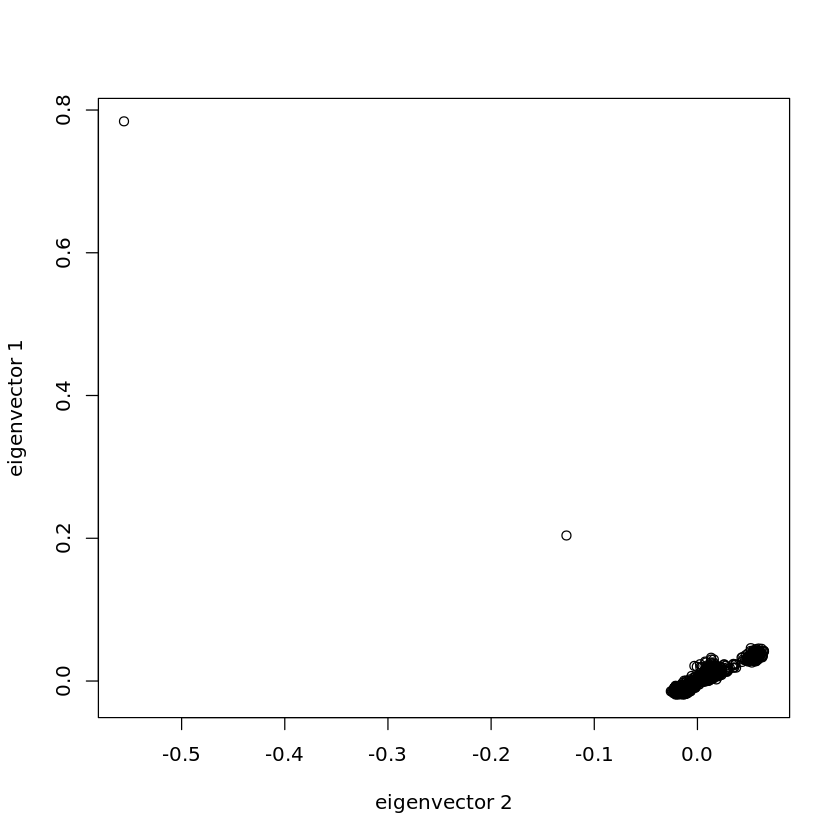

In [13]:
tab <- data.frame(sample.id=pca$sample.id, pop=factor(pop_code)[match(pca$sample.id, pca$sample.id)], EV1=pca$eigenvect[,1], EV2=pca$eigenvect[,2], stringsAsFactors=FALSE)
#head(tab)
# plot(tab$EV2, tab$EV1, col=as.integer(tab$pop), xlab="eigenvector 2", ylab="eigenvector 1")
plot(tab$EV2, tab$EV1, xlab="eigenvector 2", ylab="eigenvector 1")
# legend("bottomright", legend=levels(tab$pop), pch="o", col=1:nlevels(tab$pop))

## Plot top 5 PCs against each other 

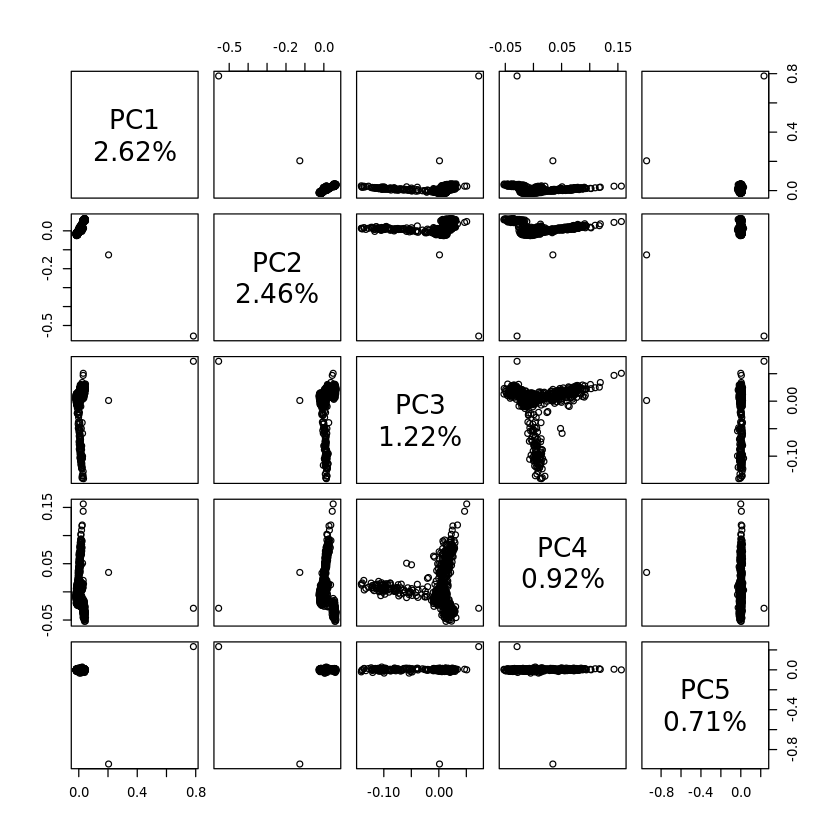

In [14]:
lbls <- paste("PC", 1:num.eigenvectors, "\n", format(pc.percent[1:num.eigenvectors], digits=2), "%", sep="")
pairs(pca$eigenvect[,1:num.eigenvectors], labels=lbls)

## Calculate SNP loadings 

In [15]:
# get SNP loadings 
snp.loadings = snpgdsPCASNPLoading(pca, genofile.atlas, num.thread=num.threads)

SNP loading:
Working space: 1264 samples, 2433 SNPs
    using 4 (CPU) cores
    using the top 32 eigenvectors
SNP Loading:    the sum of all selected genotypes (0,1,2) = 5603742
Fri Jul 27 18:43:58 2018    (internal increment: 37096)
[==================================================] 100%, completed in 0s
Fri Jul 27 18:43:58 2018    Done.


## Calculate sample loadings for testing set using SNP loadings

In [16]:
# get sample loadings
sample.loadings.1000g.train = snpgdsPCASampLoading(snp.loadings, genofile.1000g, sample.id=testing.samples.1000g, num.thread=num.threads)
sample.loadings.1000g.test = snpgdsPCASampLoading(snp.loadings, genofile.1000g, sample.id=testing.samples.1000g, num.thread=num.threads)
sample.loadings.atlas.test = snpgdsPCASampLoading(snp.loadings, genofile.atlas, sample.id=testing.samples.atlas, num.thread=num.threads)

Sample loading:
Working space: 751 samples, 2433 SNPs
    using 4 (CPU) cores
    using the top 32 eigenvectors
Sample Loading:    the sum of all selected genotypes (0,1,2) = 3334246
Fri Jul 27 18:43:58 2018    (internal increment: 62436)
[==================================================] 100%, completed in 0s
Fri Jul 27 18:43:58 2018    Done.
Sample loading:
Working space: 751 samples, 2433 SNPs
    using 4 (CPU) cores
    using the top 32 eigenvectors
Sample Loading:    the sum of all selected genotypes (0,1,2) = 3334246
Fri Jul 27 18:43:58 2018    (internal increment: 62436)
[==================================================] 100%, completed in 0s
Fri Jul 27 18:43:58 2018    Done.
Sample loading:
Working space: 542 samples, 2433 SNPs
    using 4 (CPU) cores
    using the top 32 eigenvectors
Sample Loading:    the sum of all selected genotypes (0,1,2) = 2405072
Fri Jul 27 18:43:58 2018    (internal increment: 65536)
[==================================================] 100%, comple

In [17]:
# extract list of SNPs used in PCA
snp.list = snpgdsSNPList(genofile.atlas)
snp.rs.id = snp.list$rs.id[snpset.id]
snp.chrom = snp.list$chromosome[snpset.id]
snp.pos = snp.list$position[snpset.id]

In [18]:
# create dataframe with one SNP per row
snp.df = data.frame(snp.rs.id, snp.chrom, snp.pos)
# transpose SNP loading table
snp.loadings.transposed = t(snp.loadings$snploading)
# match SNPs with loading vectors
loading.mat = data.frame(snp.df[snp.loadings$snp.id,], snp.loadings.transposed[,1:num.eigenvectors])
# write loading data frame to file
write.table(loading.mat, file=output.loading.file, quote=FALSE, sep="\t", row.names=FALSE)

## Create training and testing data frames
We pair each sample with its corresponding eigenvectors (loadings) that have been calculated above

In [19]:
# create data frames, where sample is paired with eigenvectors
train.eigenvects = data.frame(sample.loadings.1000g.train$sample.id, sample.loadings.1000g.train$eigenvect[,1:num.eigenvectors]) 
test.eigenvects  = data.frame(sample.loadings.1000g.test$sample.id, sample.loadings.1000g.test$eigenvect[,1:num.eigenvectors])
atlas.test.eigenvects = data.frame(sample.loadings.atlas.test$sample.id, sample.loadings.atlas.test$eigenvect[,1:num.eigenvectors])
# train.eigenvects = data.frame(pca$sample.id, pca$eigenvect[,1:num.eigenvectors]) 
# test.eigenvects  = data.frame(sample.loadings$sample.id, sample.loadings$eigenvect[,1:num.eigenvectors])

In [20]:
# make sure sample.id column is same for all df
colnames(train.eigenvects)[1] = "sample.id"
colnames(test.eigenvects)[1] = "sample.id"
colnames(atlas.test.eigenvects)[1] = "sample.id"
colnames(sample.info)[1] = "sample.id"

In [21]:
# merge data frames
train.df = merge(sample.info, train.eigenvects)
test.df  = merge(sample.info, test.eigenvects)
test.atlas.df  = atlas.test.eigenvects

## Train random forest model
Using a random forest classifier we will train a model to predict the *super*population, using the eigenvectors generated using PCA as input features. To test the model, we use the subset of samples we held out of the PCA training step.

In [22]:
# train random forest using training eigenvectors
# output.forest = randomForest(train.df[,5:9], y=train.df$super_pop, 
#                              data=train.df, xtest=test.df[,5:9], ytest=test.df$super_pop, 
#                              ntree=500, replace=FALSE)
output.forest = randomForest(train.df[,5:9], y=train.df$super_pop, 
                             data=train.df, 
                             ntree=500, replace=FALSE)

In [23]:
print(output.forest)


Call:
 randomForest(x = train.df[, 5:9], y = train.df$super_pop, ntree = 500,      replace = FALSE, data = train.df) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 1.07%
Confusion matrix:
    AFR AMR EAS EUR SAS class.error
AFR 211   1   0   0   0 0.004716981
AMR   1 100   0   4   0 0.047619048
EAS   0   0 157   0   0 0.000000000
EUR   0   1   0 144   1 0.013698630
SAS   0   0   0   0 131 0.000000000


In [24]:
# predict(output.forest, test.df[,5:9])
confusionMatrix(predict(output.forest, test.df[,5:9]), test.df$super_pop)

Confusion Matrix and Statistics

          Reference
Prediction AFR AMR EAS EUR SAS
       AFR 212   0   0   0   0
       AMR   0 105   0   0   0
       EAS   0   0 157   0   0
       EUR   0   0   0 146   0
       SAS   0   0   0   0 131

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9951, 1)
    No Information Rate : 0.2823     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: AFR Class: AMR Class: EAS Class: EUR Class: SAS
Sensitivity              1.0000     1.0000     1.0000     1.0000     1.0000
Specificity              1.0000     1.0000     1.0000     1.0000     1.0000
Pos Pred Value           1.0000     1.0000     1.0000     1.0000     1.0000
Neg Pred Value           1.0000     1.0000     1.0000     1.0000     1.0000
Prevalence               0.2823   

In [25]:
atlas.predictions = predict(output.forest, test.atlas.df)
atlas.counts = count(atlas.predictions)
length(atlas.predictions)
atlas.counts$frac = atlas.counts$freq/length(atlas.predictions)

[1] 542

In [26]:
atlas.counts

x,freq,frac
AFR,24,0.04428044
AMR,115,0.21217712
EAS,61,0.11254613
EUR,327,0.60332103
SAS,15,0.02767528
